In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [19]:
# find scale parameters in all the data
inputs = pd.read_csv('../../../data/Germany/input_data.csv').dropna().set_index('time')['2002-05-01':'2016-12-31']
heads = pd.read_csv('../../../data/Germany/heads.csv').dropna().set_index('Date')['2002-05-01':'2016-12-31']

dates = inputs.index
inputs = inputs.values
heads = heads.values

In [36]:
# grid search

T_list = [7,14,21]
learning_rate_list = [0.01,0.005]
hidden_size_list = [5,8,15,20]
batch_size_list = [128,256,512]
HyperParam = pd.DataFrame(np.array(np.meshgrid(T_list, learning_rate_list, hidden_size_list, batch_size_list)).T.reshape(-1, 4)).astype({0: int, 2: int, 3: int})

loss_list, val_loss_list = [], []

for idx, T, learning_rate, hidden_size, batch_size in HyperParam.itertuples():
    
    print(T, learning_rate, hidden_size, batch_size)

    D = inputs.shape[1]
    N = len(inputs) - T
    test_ratio = 0.2
    train_ratio = 1 - test_ratio
    Ntrain = int(N * train_ratio)

    x_scaler = MinMaxScaler()
    x_scaler.fit(inputs[:Ntrain])
    inputs = x_scaler.transform(inputs)

    y_scaler = MinMaxScaler()
    y_scaler.fit(heads[:Ntrain])
    heads = y_scaler.transform(heads)


    # Building sample data
    X = np.zeros((N, T, D))
    y = np.zeros(N)

    for t in range(N):
        X[t, : ,:] = inputs[t:t+T]
        y[t] = heads[t+T, 0]

    y = np.expand_dims(y, axis=1)
    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)


    dataX = Variable(torch.Tensor(X))
    dataY = Variable(torch.Tensor(y))

    trainX = Variable(torch.Tensor(X_train).cuda())
    trainY = Variable(torch.Tensor(y_train).cuda())

    testX = Variable(torch.Tensor(X_test).cuda())
    testY = Variable(torch.Tensor(y_test).cuda())


    class LSTM(nn.Module):

        def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
            super(LSTM, self).__init__()
            
            self.num_classes = num_classes
            self.num_layers = num_layers
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.seq_length = seq_length
            
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)
            
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            h_0 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size).cuda())
            
            c_0 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size).cuda())
            
            # Propagate input through LSTM
            ula, (h_out, _) = self.lstm(x, (h_0, c_0))
            
            h_out = h_out.view(-1, self.hidden_size)
            
            out = self.fc(h_out)
            
            return out


    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    num_epochs = 1000

    num_classes = 1
    num_layers = 1

    n_batches = len(trainX) // batch_size

    lstm = LSTM(num_classes, D, hidden_size, num_layers, T)
    lstm.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.0001)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    loss_history, val_loss_history = [], []
    scheduler = StepLR(optimizer, step_size=300, gamma=0.5)

    for epoch in range(num_epochs):
        shufle_index = torch.randperm(trainX.size()[0])
        shuffle_trainX, shuffle_trainY = trainX[shufle_index], trainY[shufle_index]
        
        for batch in range(n_batches):
            batch_trainX, batch_trainY = shuffle_trainX[batch*batch_size:(batch+1)*batch_size,:,:], shuffle_trainY[batch*batch_size:(batch+1)*batch_size,:]

            outputs = lstm(batch_trainX)
            val_outputs = lstm(testX)
            optimizer.zero_grad()
            
            # obtain the loss function
            loss = criterion(outputs, batch_trainY)
            val_loss = criterion(val_outputs, testY)
            
            loss.backward()
            
            optimizer.step()

        loss_history.append(criterion(lstm(trainX), trainY).item())
        val_loss_history.append(val_loss.item())

        scheduler.step()
        if epoch % 200 == 0:
            print("Epoch: %d" % (epoch))

    loss_list.append(loss_history)
    val_loss_list.append(val_loss_history)

data = np.array(loss_list)
np.savetxt("r_loss.csv", data, delimiter=", ", fmt="% s")
data = np.array(val_loss_list)
np.savetxt("r_val_loss.csv", data, delimiter=", ", fmt="% s")

7 0.01 5 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
7 0.005 5 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
14 0.01 5 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
14 0.005 5 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
21 0.01 5 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
21 0.005 5 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
7 0.01 8 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
7 0.005 8 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
14 0.01 8 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
14 0.005 8 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
21 0.01 8 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
21 0.005 8 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
7 0.01 15 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
7 0.005 15 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
14 0.01 15 128
Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Ep

In [40]:
HyperParam.iloc[i]

0     21.000
1      0.005
2     20.000
3    512.000
Name: 71, dtype: float64

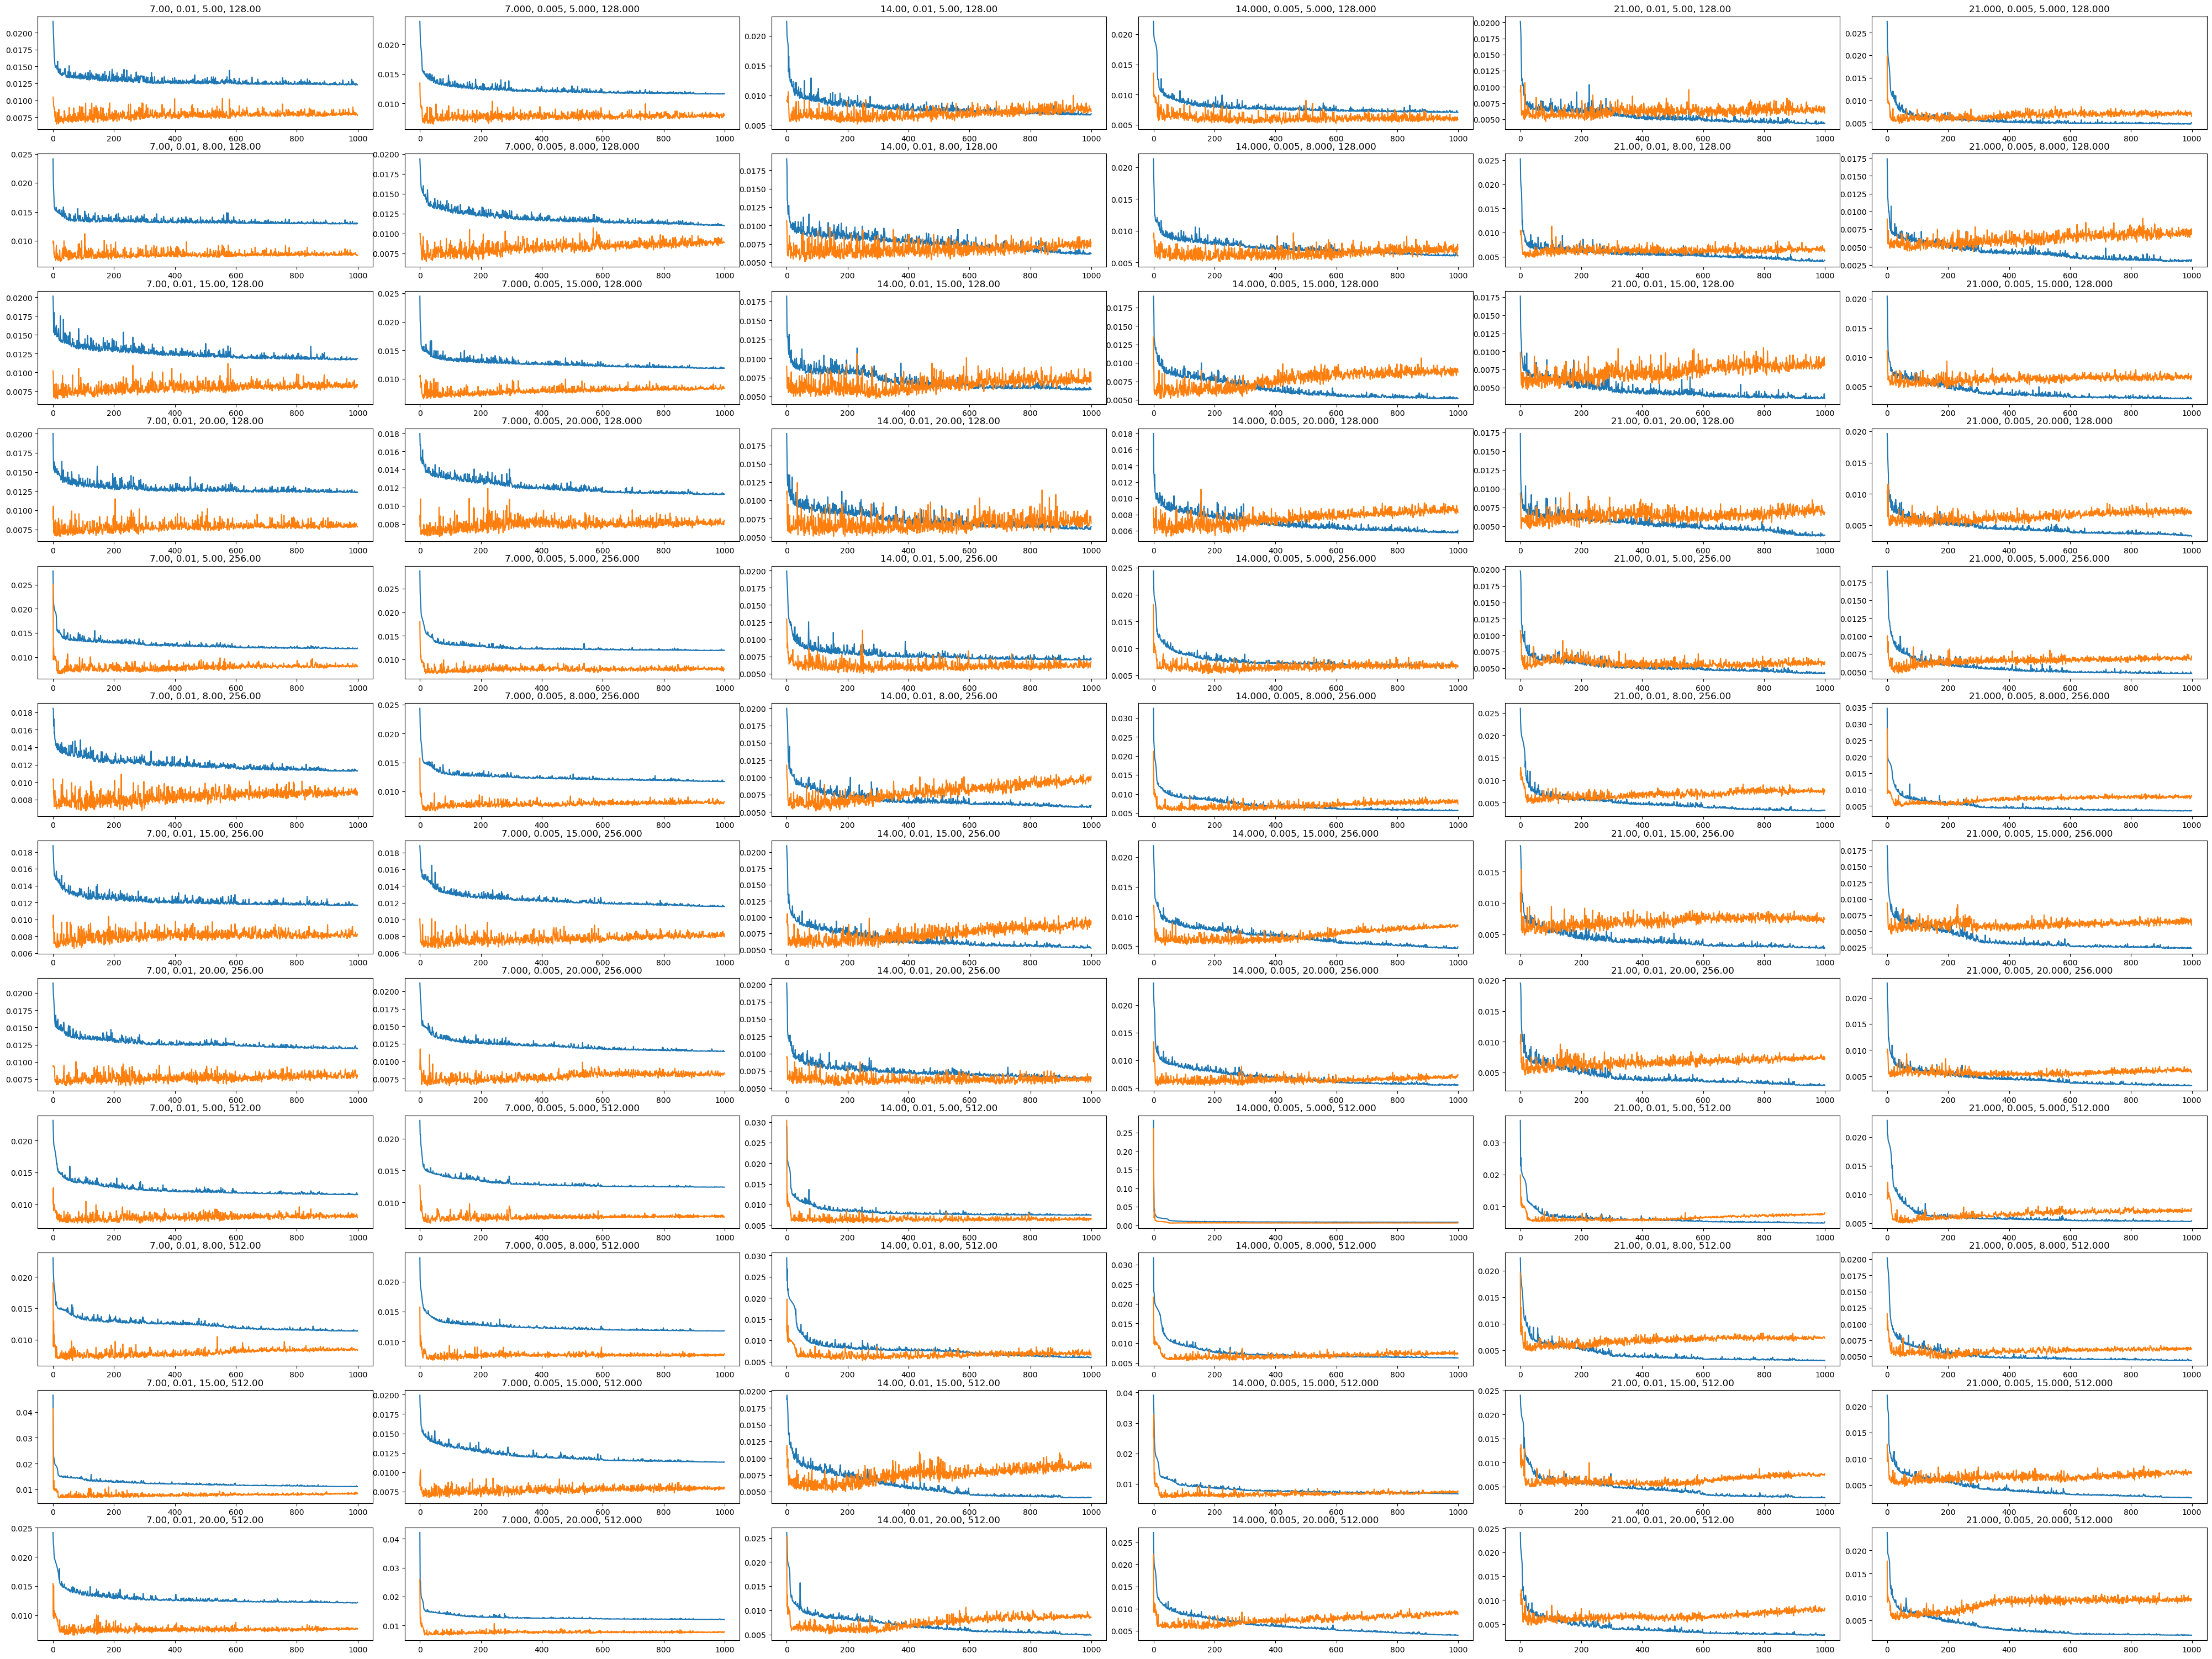

In [44]:
# hyperparameter tuning results

df_r_val_loss = pd.read_csv('r_val_loss.csv', header=None)
df_r_loss = pd.read_csv('r_loss.csv', header=None)
len(df_r_loss)

T_list = [7,14,21]
learning_rate_list = [0.01,0.005]
hidden_size_list = [5,8,15,20]
batch_size_list = [128,256,512]
HyperParam = pd.DataFrame(np.array(np.meshgrid(T_list, learning_rate_list, hidden_size_list, batch_size_list)).T.reshape(-1, 4)).astype({0: int, 2: int, 3: int})

import matplotlib.pyplot as plt

rows = 12
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(40, 30))
fig.tight_layout()
for i in range(72):
  axs[i//cols, i%cols].plot(df_r_loss.iloc[i], label='loss')
  axs[i//cols, i%cols].plot(df_r_val_loss.iloc[i], label='val_loss')
  title = str(HyperParam.iloc[i]).split()
  axs[i//cols, i%cols].set_title(str(title[1])+', '+str(title[3])+', '+str(title[5])+', '+str(title[7]))